# Koopman spectral analysis and forecasting of systems on the 2-torus

In [1]:
%load_ext nb_mypy
%nb_mypy On
    
%matplotlib ipympl

Version 1.0.4


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import nlsa.fourier_t2 as f2
import nlsa.function_algebra as fun
import nlsa.matrix_algebra as mat
import nlsa.vector_algebra as vec
import nlsa.rkhs as rkhs
import numpy as np

from functools import partial
from ipywidgets import widgets, interactive, interact, IntSlider
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from multiprocess import Pool
from nlsa.abstract_algebra import compose_by, conjugate_by, multiply_by
from nlsa.dynamics import flow, orbit, stepanoff_generator, stepanoff_vec, \
    torus_rotation
from nlsa.function_algebra import compose, fmap
from nlsa.matrix_algebra import pure_state
from nptyping import Complex, Double, Int, NDArray, Shape
from scipy import sparse
from scipy.linalg import eig
from scipy.integrate import odeint
from scipy.sparse._csr import csr_matrix
from scipy.sparse.linalg import eigs
from typing import Callable, Tuple, TypeVar

In [3]:
R = float
R2 = Tuple[float, float]
I2 = Tuple[int, int]

T2 = NDArray[Shape["2"], Double]
X = NDArray[Shape["*, 2"], Double]
Y = TypeVar("Y", NDArray[Shape["*"], Double], NDArray[Shape["*"], Complex])
F = Callable[[X], Y]

N = TypeVar("N")
K = NDArray[Shape["N"], Int]
V = TypeVar("V", NDArray[Shape["N"], Double], NDArray[Shape["N"], Complex])
VR = NDArray[Shape["N"], Double]
W = TypeVar("W",
            NDArray[Shape["*, N"], Double],
            NDArray[Shape["*, N"], Complex])
M = TypeVar("M",
            NDArray[Shape["N, N"], Double],
            NDArray[Shape["N, N"], Complex])

In [4]:
def rkha_eig(p: R, tau: R, l: int) -> Callable[[M], Tuple[V, M, VR]]:
    """Eigensolver for RKHA-regularized generator of dynamical systems on T2.
    
    :p: RKHA exponent paramneter. 
    :tau: RKHA heat flow parameter.
    :l: Maximal Fourier wavenumber.
    :returns: A function that takes as input the matrix representation of the
    raw generator in the Fourier basis, and returns as an output the 
    eigendecomposition of the regularized genertor, along with the Dirichlet 
    energies of the eigenvectors.
    
    """
    wfun = f2.rkha_weights(p, tau)
    w = wfun(f2.dual_group((l, l)))
    lamb = sparse.diags(1 / np.sqrt(w))
    regularize = conjugate_by(mat, lamb, mat, lamb) 
    engy = rkhs.energy(w)
    
    def regularized_eig(v: M) -> Tuple[V, M, VR]:
        v_tau  = regularize(v)
        omega, c = eig(v_tau)
        e = engy(c) - 1
        idx = e.argsort()
        omega = omega[idx]
        c = c[:, idx]
        e = e[idx]
        return omega, c, e
    return regularized_eig

In [5]:
def vm(kappa: R2) -> F:
    """Von Mises density centered at (pi, pi)."""
    f: F = f2.von_mises(kappa, loc=(np.pi, np.pi))
    return f


def vm_fourier(kappa: R2, l: I2) -> V:
    """Fourier coefficients of von Mises density centered at (pi, pi)."""
    vm_hat = f2.von_mises_fourier(kappa, loc=(np.pi, np.pi))
    f_hat: V = vm_hat(f2.dual_group(l))
    return f_hat
    

def vm_mult_op(kappa: R2, l: I2) -> M:
    """Projected multiplication operator induced by von Mises density.""" 
    mult_op = f2.make_mult_op(l)
    f_mult: M = mult_op(vm_fourier(kappa, (2 * l[0], 2 * l[1])))
    return f_mult

In [6]:
def feature_map(epsilon: R2, l: I2) -> Callable[[X], V]:
    """Feature map based on von Mises density."""
    kappa = (epsilon[0] ** -2, epsilon[1] ** -2)
    xi_0 = f2.von_mises_feature_map(kappa, l)
    z = np.linalg.norm(xi_0(np.array([0, 0])))
    
    def xi(x: X) -> V:
        return xi_0(x) / z
    return xi


def qm_recon(a: M, xi: Callable[[X], V]) -> F:
    """Reconstructs function from quantum mechanical observable and feature
    map.
    
    """
    def f(x: X):
        omega = pure_state(xi(x))
        return omega(a)
    return f

## Ergodic rotation

In [7]:
alpha = (1.0, np.sqrt(30))
dt = 0.1
kappa = 10

a = (dt * alpha[0], dt * alpha[1])

### True dynamics

In [8]:
phi = torus_rotation(a)
u = compose_by(fun, phi)
f = vm((kappa, kappa))

In [9]:
n_plt_x = 128
n_iter = 100
plt_range = (-1, 70)
i_fig = 1

f_orb = orbit(f, u)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = f(x)
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Ergodic rotation; $t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j'), Output()), _dom_classes=('…

### RKHS regularization

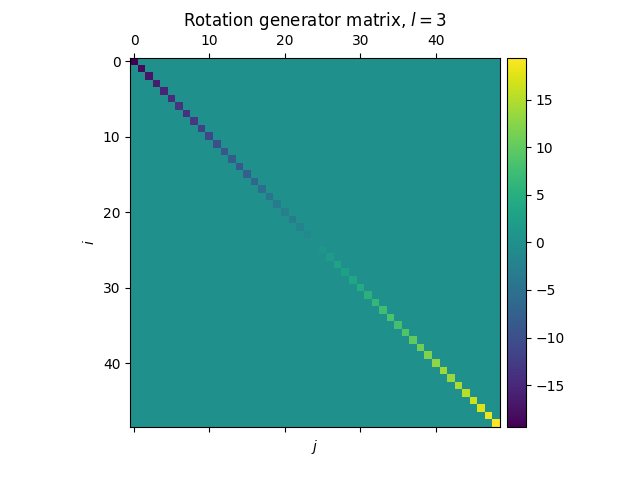

In [10]:
l = 3

v = f2.rotation_generator(alpha, l)

i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
im = ax.matshow(np.imag(v))
cb = fig.colorbar(im, cax=cax)
ax.set_xlabel("$j$")
ax.set_ylabel("$i$")
ax.set_title(f"Rotation generator matrix, $l={l}$")
plt.show()

In [11]:
l = 8
p = 0.5
tau = 0.0005

regularized_eig = rkha_eig(p, tau, l)
v = f2.rotation_generator(alpha, l)
omega, c, e = regularized_eig(v)

to_zeta_vec = compose_by(mat, c)
to_zeta_mat = conjugate_by(mat, c.T.conj(), mat, c)
phi = f2.fourier_basis(f2.dual_group((l, l)))
zeta = compose(to_zeta_vec, phi)
synth_phi = partial(fun.synthesis, phi)
synth_zeta = partial(fun.synthesis, zeta)

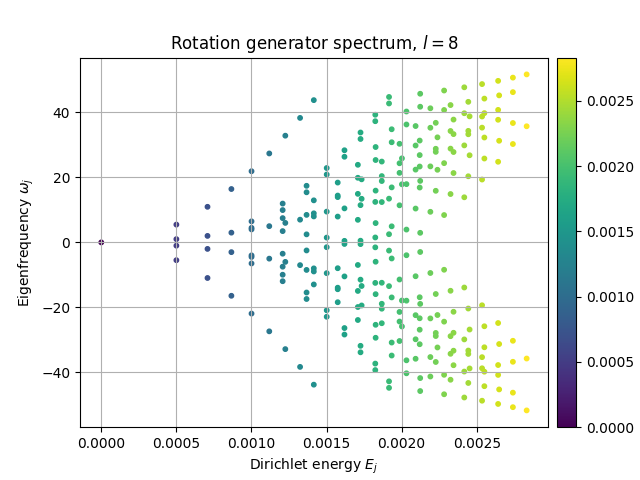

In [12]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")
im = ax.scatter(e, np.imag(omega), s=10, c=e)
cb = fig.colorbar(im, cax=cax)
ax.grid(True)
ax.set_xlabel("Dirichlet energy $E_j$")
ax.set_ylabel("Eigenfrequency $\\omega_j$")
ax.set_title(f"Rotation generator spectrum, $l={l}$")
plt.show()

In [13]:
n_plt_x = 128
n_plt_eig = 20
i_fig = 4

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    f = synth_phi(c[:, j])
    fx = np.real(f(x))
    om = np.imag(omega[j])
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Rotation eigenfunction $\zeta_{{{j}}}$, "
                  + f"$\omega_{{{j}}} = {om:.3f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=20), Output()), _dom_cl…

### Classical approximation

In [14]:
u = multiply_by(vec, np.exp(omega * dt))
f_hat = np.inner(np.conj(c.T), vm_fourier((kappa, kappa), (l, l)))

In [15]:
n_plt_x = 128
n_iter = 50
plt_range = (-1, 70)
i_fig = 5

f_hat_orb = orbit(f_hat, u)
f_orb  = map(synth_zeta, f_hat_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Classical approximation of ergodic rotation; "
                 f"$t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=50), Output()), _dom_cl…

### Quantum mechanical approximation

In [16]:
epsilon = 0.2

u_adj = fmap(multiply_by(vec, np.exp(-omega * dt)))
f_mult = to_zeta_mat(vm_mult_op((kappa, kappa), (l, l)))
make_qm_recon = partial(qm_recon, f_mult)
xi = compose(to_zeta_vec, feature_map((epsilon, epsilon), (l, l)))

In [17]:
n_plt_x = 128
n_iter = 50
n_par = 3
plt_range = (-1, 70)
i_fig = 6

pl = Pool(n_par)
xi_orb = orbit(xi, u_adj)
f_orb  = map(make_qm_recon, xi_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(pl.map(f, x))
    #fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("QM approximation of ergodic rotation; "
                 f"$t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=50), Output()), _dom_cl…

## Stepanoff flow

In [18]:
alpha = np.sqrt(20)
dt = 0.1
kappa = 10

### True dynamics

In [19]:
u = compose_by(fun, flow(stepanoff_vec(alpha), dt))
f = vm((kappa, kappa))

In [20]:
n_plt_x = 64
n_iter = 100
n_par = 6
plt_range = (-1, 70)
i_fig = 11

pl = Pool(n_par)
f_orb = orbit(f, u)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi
x = np.reshape(x, ((n_plt_x - 1) ** 2, 2))

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = pl.map(f, x)
    fx = np.reshape(fx, (n_plt_x - 1, n_plt_x - 1))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff flow; $t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j'), Output()), _dom_classes=('…

### RKHS regularization

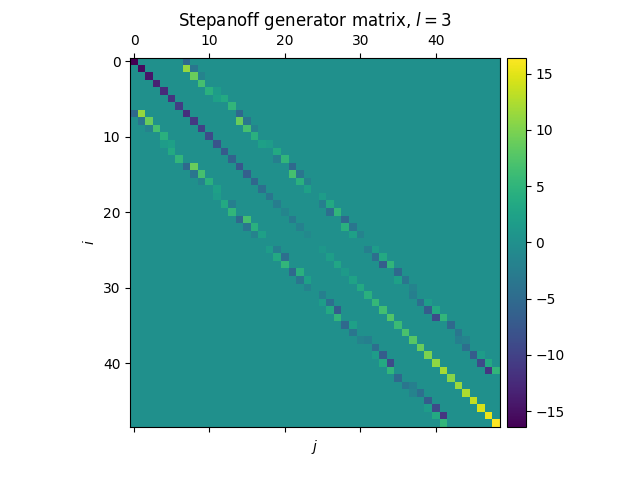

In [21]:
l = 3
i_fig = 12

v: csr_matrix = stepanoff_generator(alpha, l)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
im = ax.matshow(np.imag(v.todense()))
cb = fig.colorbar(im, cax=cax)
ax.set_xlabel("$j$")
ax.set_ylabel("$i$")
ax.set_title(f"Stepanoff generator matrix, $l={l}$")
plt.show()

In [37]:
l = 8
p = 0.5
tau = 0.0005

regularized_eig = rkha_eig(p, tau, l)
v: csr_matrix = stepanoff_generator(alpha, l)
omega, c, e = regularized_eig(v.todense())

to_zeta_vec = compose_by(mat, c)
to_zeta_mat = conjugate_by(mat, c.T.conj(), mat, c)
phi = f2.fourier_basis(f2.dual_group((l, l)))
zeta = compose(to_zeta_vec, phi)
synth_phi = partial(fun.synthesis, phi)
synth_zeta = partial(fun.synthesis, zeta)

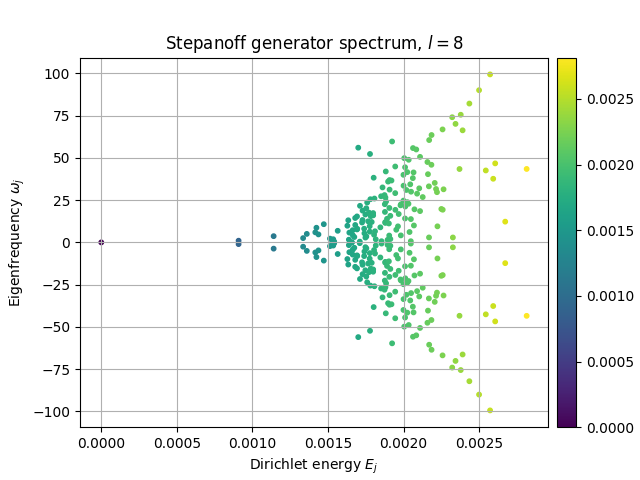

In [38]:
i_fig = 13

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")
im = ax.scatter(e, np.imag(omega), s=10, c=e)
cb = fig.colorbar(im, cax=cax)
ax.grid(True)
ax.set_xlabel("Dirichlet energy $E_j$")
ax.set_ylabel("Eigenfrequency $\\omega_j$")
ax.set_title(f"Stepanoff generator spectrum, $l={l}$")
plt.show()

In [39]:
n_plt_x = 64
n_plt_eig = 20
i_fig = 14

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    f = synth_phi(c[:, j])
    fx = np.real(f(x))
    om = np.imag(omega[j])
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title(f"Stepanoff eigenfunction $\zeta_{{{j}}}$, "
                  + f"$\omega_{{{j}}} = {om:.3f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=20), Output()), _dom_cl…

### Classical approximation

In [40]:
f_hat = np.inner(np.conj(c.T), vm_fourier((kappa, kappa), (l, l)))
u = multiply_by(vec, np.exp(omega * dt))

In [41]:
n_plt_x = 64
n_iter = 100
plt_range = (-1, 70)
i_fig = 15

f_hat_orb = orbit(f_hat, u)
f_orb  = map(synth_zeta, f_hat_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("Classical approximation of Stepanoff flow; "
                 f"$t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j'), Output()), _dom_classes=('…

### Quantum mechanical approximation

In [42]:
epsilon = 0.1

u_adj = fmap(multiply_by(vec, np.exp(-omega * dt)))
f_mult = to_zeta_mat(vm_mult_op((kappa, kappa), (l, l)))
make_qm_recon = partial(qm_recon, f_mult)
xi = compose(to_zeta_vec, feature_map((epsilon, epsilon), (l, l)))

In [43]:
n_plt_x = 64
n_iter = 50
n_par = 6
plt_range = (-1, 70)
i_fig = 16

pl = Pool(n_par)
xi_orb = orbit(xi, u_adj)
f_orb  = map(make_qm_recon, xi_orb)
fn = take(n_iter + 1, f_orb) 

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
divnorm = mpl.colors.TwoSlopeNorm(vmin=plt_range[0], vmax=plt_range[1],
                                  vcenter=0)
j_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    t = j * dt
    f = fn[j]
    fx = np.real(pl.map(f, x))
    #fx = np.real(f(x))
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, fx, cmap="seismic", norm=divnorm)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_title("QM approximation of Stepanoff flow; "
                 f"$t = {t:.2f}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=50), Output()), _dom_cl…